# <span style ='color:#0A1172'>DHHS Chronic Disease Indicators: COPD Prevalance Analysis
## <span style ='color:#59788E'> <bu>EXPLORATORY NOTEBOOK</bu>

- <span style ='color:#016064'>by Annie Carter
- <span style ='color:#016064'>Sourced by U.S. Department of Health & Human Services

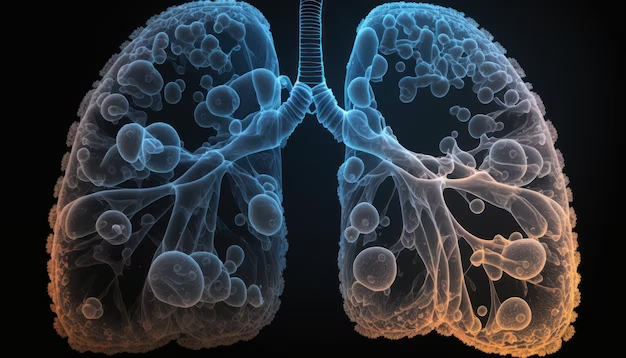

 Custom Palette = Navy #0A1172, Stone #59788E, Ocean #757C88, Berry #241571

In [98]:
#IMPORT LIBRARIES
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import os
import folium

import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr


# import Machine Learning Library for classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import pearsonr, spearmanr

import datetime
import warnings
warnings.filterwarnings("ignore")


## <span style ='color:#241571'>ACQUIRE

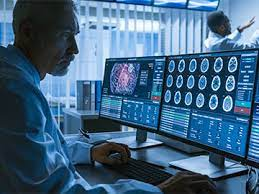

In [2]:
# Save and read dataset csv from https://catalog.data.gov/dataset/u-s-chronic-disease-indicators-cdi
df = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI_.csv')

/var/folders/0f/gkm6knzn3fscjt7dxlgc9k5h0000gn/T/ipykernel_15465/2347781156.py:2: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI_.csv')


In [3]:
# Review shape to determine processing needs, will use sample size due to network restrictions for exploration
df.shape

(1185676, 34)

In [4]:
#Review data to look at columns datatypes and nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1185676 entries, 0 to 1185675
Data columns (total 34 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   YearStart                  1185676 non-null  int64  
 1   YearEnd                    1185676 non-null  int64  
 2   LocationAbbr               1185676 non-null  object 
 3   LocationDesc               1185676 non-null  object 
 4   DataSource                 1185676 non-null  object 
 5   Topic                      1185676 non-null  object 
 6   Question                   1185676 non-null  object 
 7   Response                   0 non-null        float64
 8   DataValueUnit              1033553 non-null  object 
 9   DataValueType              1185676 non-null  object 
 10  DataValue                  806942 non-null   object 
 11  DataValueAlt               804578 non-null   float64
 12  DataValueFootnoteSymbol    393710 non-null   object 
 13  DatavalueFoo

In [5]:
# Quick review of data in columns started with 40 then transpose for readiability with head of 5
df.head().T

,0,1,2,3,4
YearStart,2014,2018,2018,2017,2010
YearEnd,2014,2018,2018,2017,2010
LocationAbbr,AR,CO,DC,GA,MI
LocationDesc,Arkansas,Colorado,District of Columbia,Georgia,Michigan
DataSource,SEDD; SID,SEDD; SID,SEDD; SID,SEDD; SID,SEDD; SID
Topic,Asthma,Asthma,Asthma,Asthma,Asthma
Question,Hospitalizations for asthma,Hospitalizations for asthma,Hospitalizations for asthma,Hospitalizations for asthma,Hospitalizations for asthma
Response,NaN,NaN,NaN,NaN,NaN
DataValueUnit,NaN,NaN,NaN,NaN,NaN
DataValueType,Number,Number,Number,Number,Number


In [6]:
filtered_df = df.loc[(df['Topic'] == 'Chronic Obstructive Pulmonary Disease') & (df['Question'].notnull())]
filtered_unique_counts = filtered_df['Question'].value_counts()
print(filtered_unique_counts)


Hospitalization for chronic obstructive pulmonary disease as first-listed diagnosis among Medicare-eligible persons aged >= 65 years    13728
Hospitalization for chronic obstructive pulmonary disease as any diagnosis among Medicare-eligible persons aged >= 65 years             13728
Mortality with chronic obstructive pulmonary disease as underlying cause among adults aged >= 45 years                                  13497
Mortality with chronic obstructive pulmonary disease as underlying or contributing cause among adults aged >= 45 years                  13497
Prevalence of chronic obstructive pulmonary disease among adults >= 18                                                                   9570
Prevalence of chronic obstructive pulmonary disease among adults >= 45 years                                                             9570
Prevalence of current smoking among adults >= 45 years with diagnosed chronic obstructive pulmonary disease                              9570
Preval

## <span style ='color:#241571'>PREPARE
Initally reduced sample dataframe to 100K to rapidly review and clean. After 1st interation recommended to remove DataValue column which reduced the sample size and created duplicates. Increased sample size to 500K for 2nd interation

In [7]:
#created sample DF with random state of 42 to review and clean data rapidly
df_sample= df.sample(n=1000000, random_state=42)


In [8]:
columns_to_remove = ['YearEnd', 'Response', 'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'DataValue',
                     'Stratification3', 'ResponseID', 'StratificationCategoryID2', 'StratificationID2',
                     'StratificationCategoryID3', 'StratificationID3','DataValueTypeID','QuestionID', 'TopicID','LocationID','HighConfidenceLimit','LowConfidenceLimit','YearEnd','LocationDesc','DataValueUnit','DataValueType','DataValueAlt','DataValueFootnoteSymbol','DatavalueFootnote','StratificationCategoryID1','StratificationID1','Question','DataSource']
# Drop unnecessary columns from the Dataframe
df_sample = df_sample.drop(columns_to_remove, axis=1)

In [9]:
df_sample.head()

,YearStart,LocationAbbr,Topic,StratificationCategory1,Stratification1,GeoLocation
392116,2017,NV,Cardiovascular Disease,Race/Ethnicity,"White, non-Hispanic",POINT (-117.07184056399967 39.493240390000494)
471795,2019,NC,"Nutrition, Physical Activity, and Weight Status",Race/Ethnicity,"Asian, non-Hispanic",POINT (-79.15925046299964 35.466220975000454)
580253,2012,AZ,Diabetes,Race/Ethnicity,Hispanic,POINT (-111.76381127699972 34.865970280000454)
1113792,2011,VA,Cardiovascular Disease,Race/Ethnicity,Hispanic,POINT (-78.45789046299967 37.54268067400045)
707447,2017,ID,Tobacco,Race/Ethnicity,Hispanic,POINT (-114.3637300419997 43.682630005000476)


In [10]:
df_sample = df_sample.rename(columns={'YearStart':'Year', 'Stratification1':'Demographics','GeoLocation':'Geo Location', 'LocationAbbr' : 'State Abbr','Topic': 'Disease'})


In [11]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 392116 to 1103867
Data columns (total 6 columns):
 #   Column                   Non-Null Count    Dtype 
---  ------                   --------------    ----- 
 0   Year                     1000000 non-null  int64 
 1   State Abbr               1000000 non-null  object
 2   Disease                  1000000 non-null  object
 3   StratificationCategory1  1000000 non-null  object
 4   Demographics             1000000 non-null  object
 5   Geo Location             991383 non-null   object
dtypes: int64(1), object(5)
memory usage: 53.4+ MB


In [12]:
def get_copd_data(df_sample):
    '''This function creates a csv '''
    # Assuming you have a function 'get_wine()' that retrieves the wine data and returns a DataFrame
    copd = df_sample

    # Save the DataFrame to a CSV file
    df_sample.to_csv("COPD.csv", index=False)  

    filename = 'COPD.csv'
    if os.path.isfile(filename):
        return pd.read_csv(filename)

In [13]:
df_sample = get_copd_data(df_sample)

In [14]:
df_sample.Demographics.value_counts()

Overall                             140281
Hispanic                            124265
White, non-Hispanic                 124136
Black, non-Hispanic                 123729
Male                                118688
Female                              118600
Other, non-Hispanic                  71892
Multiracial, non-Hispanic            71729
American Indian or Alaska Native     53176
Asian or Pacific Islander            50733
Asian, non-Hispanic                   2771
Name: Demographics, dtype: int64

In [15]:
df_sample.shape

(1000000, 6)

In [16]:
#Sample size has a equal distribution by US State and terroritory Reviewed during initial exploration using .head(20)
df_sample['State Abbr'].value_counts().head(2)

WI    19067
NJ    19066
Name: State Abbr, dtype: int64

In [17]:
df_sample['Disease'].value_counts()

Cancer                                             148507
Cardiovascular Disease                             133143
Diabetes                                           132121
Chronic Obstructive Pulmonary Disease              128701
Asthma                                              67973
Arthritis                                           66000
Nutrition, Physical Activity, and Weight Status     63749
Overarching Conditions                              61937
Alcohol                                             55831
Tobacco                                             49934
Older Adults                                        22089
Chronic Kidney Disease                              20989
Oral Health                                         18798
Mental Health                                       11210
Immunization                                         7977
Reproductive Health                                  7707
Disability                                           3334
Name: Disease,

In [18]:
# List of values to remove from the 'Topic' column
values_to_remove = ['Asthma', 'Arthritis', 'Nutrition, Physical Activity, and Weight Status', 'Overarching Conditions','Alcohol','Tobacco','Chronic Kidney Disease','Older Adults','Oral Health','Mental Health','Immunization','Reproductive Health','Disability']

# Drop rows with specific values from the 'Topic' column
df_sample = df_sample.drop(df_sample[df_sample['Disease'].isin(values_to_remove)].index)

df_sample.Disease.value_counts()


Cancer                                   148507
Cardiovascular Disease                   133143
Diabetes                                 132121
Chronic Obstructive Pulmonary Disease    128701
Name: Disease, dtype: int64

In [19]:
# Will use COPD to create one-hot code "dummy" value for prevalaence \n"Yes_COPD" and Cardiovascular Disease, Diabetes & COPD \n . I will remove other Topics reduce date to  
# Create a dummy variable for the 'Disease' column
df_sample['Yes_COPD'] = np.where(df_sample['Disease'] == 'Chronic Obstructive Pulmonary Disease', 1, 0).astype(int)

# Drop the original 'Disease' column
df_sample.drop('Disease', axis=1, inplace=True)

df_sample.head()

,Year,State Abbr,StratificationCategory1,Demographics,Geo Location,Yes_COPD
0,2017,NV,Race/Ethnicity,"White, non-Hispanic",POINT (-117.07184056399967 39.493240390000494),0
2,2012,AZ,Race/Ethnicity,Hispanic,POINT (-111.76381127699972 34.865970280000454),0
3,2011,VA,Race/Ethnicity,Hispanic,POINT (-78.45789046299967 37.54268067400045),0
5,2014,UT,Gender,Male,POINT (-111.58713063499971 39.360700171000474),0
7,2008,AL,Gender,Male,POINT (-86.63186076199969 32.84057112200048),0


In [20]:
#Find nulls
df_sample.isnull().sum()

Year                          0
State Abbr                    0
StratificationCategory1       0
Demographics                  0
Geo Location               5065
Yes_COPD                      0
dtype: int64

In [21]:
df_sample.dropna(subset=['Geo Location',], inplace=True)

In [22]:
df_sample.isnull().sum()

Year                       0
State Abbr                 0
StratificationCategory1    0
Demographics               0
Geo Location               0
Yes_COPD                   0
dtype: int64

In [23]:
df_sample.shape

(537407, 6)

In [24]:
#Find duplicates
df_sample.duplicated().sum()

524136

In [25]:
#Instructed to remove DataValues which made rows more distinguisable must keep rows due to limited columns at this point because they are not true duplicates
# df_sample.drop_duplicates(inplace=True)

In [26]:
df_sample.head(2)

,Year,State Abbr,StratificationCategory1,Demographics,Geo Location,Yes_COPD
0,2017,NV,Race/Ethnicity,"White, non-Hispanic",POINT (-117.07184056399967 39.493240390000494),0
2,2012,AZ,Race/Ethnicity,Hispanic,POINT (-111.76381127699972 34.865970280000454),0


In [27]:
df_sample.shape

(537407, 6)

In [28]:
# Create a new column 'Race/Ethnicity' based on the condition
df_sample['Race/Ethnicity'] = np.where(df_sample.StratificationCategory1 == 'Race/Ethnicity', df_sample.Demographics, '')

df_sample.head(2)



,Year,State Abbr,StratificationCategory1,Demographics,Geo Location,Yes_COPD,Race/Ethnicity
0,2017,NV,Race/Ethnicity,"White, non-Hispanic",POINT (-117.07184056399967 39.493240390000494),0,"White, non-Hispanic"
2,2012,AZ,Race/Ethnicity,Hispanic,POINT (-111.76381127699972 34.865970280000454),0,Hispanic


In [29]:
# Create a new column 'Gender' based on the condition
df_sample['Gender'] = np.where(df_sample.StratificationCategory1 == 'Gender', df_sample.Demographics, '')

df_sample.head(2)


,Year,State Abbr,StratificationCategory1,Demographics,Geo Location,Yes_COPD,Race/Ethnicity,Gender
0,2017,NV,Race/Ethnicity,"White, non-Hispanic",POINT (-117.07184056399967 39.493240390000494),0,"White, non-Hispanic",
2,2012,AZ,Race/Ethnicity,Hispanic,POINT (-111.76381127699972 34.865970280000454),0,Hispanic,


In [30]:
# Will use Female to create one-hot code "dummy" value for "female" 
df_sample['Yes_female'] = np.where(df_sample['Gender'] == 'Female', 1, 0).astype(int)

df_sample.head(2)

,Year,State Abbr,StratificationCategory1,Demographics,Geo Location,Yes_COPD,Race/Ethnicity,Gender,Yes_female
0,2017,NV,Race/Ethnicity,"White, non-Hispanic",POINT (-117.07184056399967 39.493240390000494),0,"White, non-Hispanic",,0
2,2012,AZ,Race/Ethnicity,Hispanic,POINT (-111.76381127699972 34.865970280000454),0,Hispanic,,0


In [31]:
# Get the value counts of 'COPD' topic
male_value_counts = df_sample[df_sample['Demographics'] == 'Male']['Demographics'].value_counts()
male_value_counts 

Male    65385
Name: Demographics, dtype: int64

In [32]:
# Get the value counts of 'COPD' topic
female_value_counts = df_sample[df_sample['Demographics'] == 'Female']['Demographics'].value_counts()
female_value_counts 

Female    65171
Name: Demographics, dtype: int64

In [33]:
df_sample.Yes_female.value_counts()

0    472236
1     65171
Name: Yes_female, dtype: int64

In [34]:
# Get the value counts of 'COPD' topic in the 'Demographic' column
demographic_value_counts = df_sample['Demographics'].value_counts()
demographic_value_counts 


Overall                             69057
Hispanic                            67737
White, non-Hispanic                 67505
Black, non-Hispanic                 67437
Male                                65385
Female                              65171
Asian or Pacific Islander           39854
American Indian or Alaska Native    39743
Other, non-Hispanic                 27797
Multiracial, non-Hispanic           27721
Name: Demographics, dtype: int64

In [35]:
# Get the value counts of 'COPD' topic in the 'Demographic' column
demographic_value_counts_with_COPD = df_sample[df_sample['Yes_COPD'] == 1]['Demographics'].value_counts()
demographic_value_counts_with_COPD

Overall                             16555
Male                                15915
Hispanic                            15883
White, non-Hispanic                 15876
Female                              15853
Black, non-Hispanic                 15839
Asian or Pacific Islander            8856
American Indian or Alaska Native     8811
Multiracial, non-Hispanic            7097
Other, non-Hispanic                  7093
Name: Demographics, dtype: int64

In [36]:
# Get the value counts of 'COPD' topic
COPD_value_counts = df_sample['Yes_COPD'].value_counts()
COPD_value_counts

0    409629
1    127778
Name: Yes_COPD, dtype: int64

In [37]:
total_with_COPD = (df_sample['Yes_COPD'] == 1).sum()
total_with_COPD

127778

In [38]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537407 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   Year                     537407 non-null  int64 
 1   State Abbr               537407 non-null  object
 2   StratificationCategory1  537407 non-null  object
 3   Demographics             537407 non-null  object
 4   Geo Location             537407 non-null  object
 5   Yes_COPD                 537407 non-null  int64 
 6   Race/Ethnicity           537407 non-null  object
 7   Gender                   537407 non-null  object
 8   Yes_female               537407 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 41.0+ MB


In [39]:
# Extract latitude and longitude from 'Geo Location' column
df_sample[['Longitude', 'Latitude']] = df_sample['Geo Location'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)')

# # Convert the latitude and longitude values to float
# df['Longitude'] = df['Longitude'].astype(float)
# df['Latitude'] = df['Latitude'].astype(float)


In [40]:
# # Convert the latitude and longitude values to float
df_sample['Longitude'] = df_sample['Longitude'].astype(float)
df_sample['Latitude'] = df_sample['Latitude'].astype(float)

In [41]:


# def split_row_by_value(df_sample, column_name):
#     rows_to_concat = []
    
#     for idx, row in df_sample.iterrows():
#         value_to_split = row['Observations']
#         if isinstance(value_to_split, int) and value_to_split > 1:
#             new_rows = [row.copy() for _ in range(value_to_split - 1)]
#             new_values = range(1, value_to_split)
#             for i, value in enumerate(new_values):
#                 new_rows[i]['Observations'] = value
#             rows_to_concat.extend(new_rows)
    
#     expand_df = pd.concat([df_sample] + rows_to_concat, ignore_index=True)
#     return expand_df






In [42]:
# expand_df = split_row_by_value(df_sample, 'Data_Value')

In [43]:
# expand_df.head()

In [44]:
# expand_df = split_row_by_value(df_sample, 'DataValue')
# expand_df.info()

### <span style ='color:#016064'>PREPARATION SUMMARY
After starting with original dataset of 1M+ I reduced it to 100K to rapidly clean and prepare for MVP. The data appeared to be distrubuted equally between states and within the 4 chronic diseases selected overall. If 10675 is too small. I can revert to original dataset using the same preparation used on the 100K df_sample. 

In [45]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 537407 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Year                     537407 non-null  int64  
 1   State Abbr               537407 non-null  object 
 2   StratificationCategory1  537407 non-null  object 
 3   Demographics             537407 non-null  object 
 4   Geo Location             537407 non-null  object 
 5   Yes_COPD                 537407 non-null  int64  
 6   Race/Ethnicity           537407 non-null  object 
 7   Gender                   537407 non-null  object 
 8   Yes_female               537407 non-null  int64  
 9   Longitude                537407 non-null  float64
 10  Latitude                 537407 non-null  float64
dtypes: float64(2), int64(3), object(6)
memory usage: 49.2+ MB


### <span style ='color:#016064'>PREPARATION FUNCTIONS FOR FINAL NOTEBOOK 

In [46]:
def prep_copd():
    ''' 
     The below functions prepares DHSS CDI for COPD prevalance analysis 
    '''
    # Save and read dataset csv from https://catalog.data.gov/dataset/u-s-chronic-disease-indicators-cdi
    df = pd.read_csv('U.S._Chronic_Disease_Indicators__CDI_.csv')
    
    #created sample DF with random state of 42 to review and clean data rapidly
    df_sample= df.sample(n=1000000, random_state=42)
    
    # List of columns to remove from Dataframe. 
    columns_to_remove = ['YearEnd', 'Response', 'StratificationCategory2', 'Stratification2', 'StratificationCategory3', 'DataValue',
                     'Stratification3', 'ResponseID', 'StratificationCategoryID2', 'StratificationID2',
                     'StratificationCategoryID3', 'StratificationID3','DataValueTypeID','QuestionID', 'TopicID','LocationID','HighConfidenceLimit','LowConfidenceLimit','YearEnd','LocationDesc','DataValueUnit','DataValueType','DataValueAlt','DataValueFootnoteSymbol','DatavalueFootnote','StratificationCategoryID1','StratificationID1','Question','DataSource']
    # Drop unnecessary columns from the Dataframe
    df_sample = df_sample.drop(columns_to_remove, axis=1)
    
     #change column names to be more readable
    df_sample = df_sample.rename(columns={'YearStart':'Year', 'Stratification1':'Demographics','GeoLocation':'Geo Location', 'LocationAbbr' : 'State Abbr','Topic': 'Disease'})
    
    # List of values to remove from the 'Topic' column
    values_to_remove = ['Asthma', 'Arthritis', 'Nutrition, Physical Activity, and Weight Status', 'Overarching Conditions','Alcohol','Tobacco','Chronic Kidney Disease','Older Adults','Oral Health','Mental Health','Immunization','Reproductive Health','Disability']

    # Extract latitude and longitude from 'Geo Location' column
    df_sample[['Longitude', 'Latitude']] = df_sample['Geo Location'].str.extract(r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)')
    # Convert the latitude and longitude values to float
    df_sample['Longitude'] = df_sample['Longitude'].astype(float)
    df_sample['Latitude'] = df_sample['Latitude'].astype(float)
    
    # Drop rows with specific values from the 'Topic' column
    df_sample = df_sample.drop(df_sample[df_sample['Disease'].isin(values_to_remove)].index)
    
    

    ''' Will use COPD to create one-hot code "dummy" value for prevalaence "Yes_COPD" and Cardiovascular Disease, Diabetes & COPD. I will remove other Topics column '''
    # Create a dummy variable for the 'Yes_COPD' column
    df_sample['Yes_COPD'] = np.where(df_sample['Disease'] == 'Chronic Obstructive Pulmonary Disease', 1, 0).astype(int)
    # Drop the original 'Disease' column
    df_sample.drop('Disease', axis=1, inplace=True)
    
    # Create a new column 'Race/Ethnicity' based on the condition
    df_sample['Race/Ethnicity'] = np.where(df_sample.StratificationCategory1 == 'Race/Ethnicity', df_sample.Demographics, '')

    # Create a new column 'Race/Gender' based on the condition
    df_sample['Gender'] = np.where(df_sample.StratificationCategory1 == 'Gender', df_sample.Demographics, '')
    
    # Will use Female to create one-hot code "dummy" value for "female" 
    df_sample['Yes_female'] = np.where(df_sample['Gender'] == 'Female', 1, 0).astype(int)

    #Remove nulls
    df_sample.dropna(inplace=True)
    
    ''' This function creates a csv '''
    cdi = df_sample

    # Save the DataFrame to a CSV file
    df_sample.to_csv("COPD.csv", index=False)  

    filename = 'COPD.csv'
    if os.path.isfile(filename):
        pd.read_csv(filename)
    return df_sample


In [47]:
def get_copd_csv(df_sample):
    '''This function creates a csv '''
    # Assuming you have a function 'cdi)' that retrieves the DHHS CDI data and returns a DataFrame
    cdi = df_sample

    # Save the DataFrame to a CSV file
    df_sample.to_csv("cdi.csv", index=False)  

    filename = 'cdi.csv'
    if os.path.isfile(filename):
        return pd.read_csv(filename)


In [48]:
def race_gender(df):
    # Create a new column 'Race/Ethnicity' based on the condition
    df_sample['Race/Ethnicity'] = np.where(df_sample.StratificationCategory1 == 'Race/Ethnicity', df_sample.Demographics, '')
    # Create a new column 'Gender' based on the condition
    df_sample['Gender'] = np.where(df_sample.StratificationCategory1 == 'Gender', df_sample.Demographics, '')
    # Will use Female to create one-hot code "dummy" value for "female" if needed for classification models
    #df_sample['Yes_female'] = np.where(df_sample['Gender'] == 'Female', 1, 0).astype(int)
    

## <span style ='color:#241571'>INITIAL EXPLORE

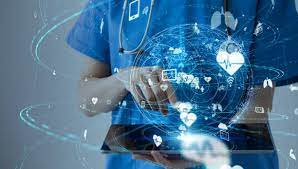

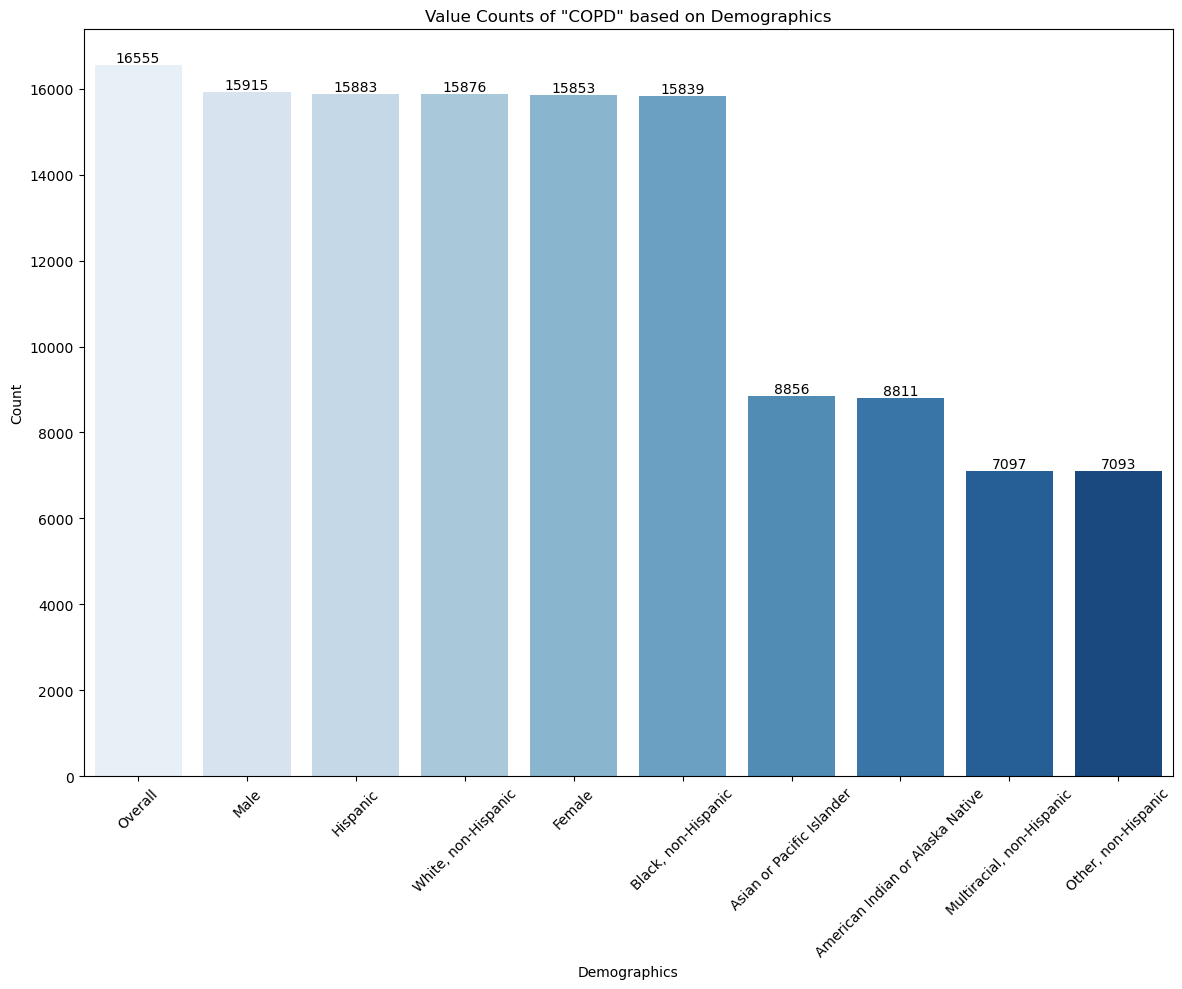

In [49]:
def demographic_graph(df_sample):
    # Get the value counts of 'Cancer' topic in the 'Demographics' column
    demo_copd = df_sample[df_sample['Yes_COPD'] == 1]['Demographics'].value_counts()
    
    # Create a bar plot using Seaborn
    plt.figure(figsize=(12, 10))
    dc = sns.barplot(x=demo_copd.index, y=demo_copd.values, palette='Blues')
    
    # Set labels and title
    plt.xlabel('Demographics')
    plt.ylabel('Count')
    plt.title('Value Counts of "COPD" based on Demographics')
              
    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    
    # Add count numbers on bars
    for p in dc.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()    
        offset = width * 0.02  # Adjust the offset percentage as needed
        dc.annotate(format(height, '.0f'), (x + width / 2., y + height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    # Show the plot
    plt.tight_layout()  
    plt.show()
demographic_graph(df_sample)

## <span style ='color:#241571'> DATA SPLIT

In [50]:
def split_sample(df):
    ''' The below functions were created in regression excercises and will be aggregated to make a master clean_data function for final 
        report
    '''
    train_validate, sample_test = train_test_split(df_sample, test_size=0.2, random_state=42)
    sample_train, sample_validate = train_test_split(train_validate, test_size=0.25, random_state=42)
    print(f'Train shape: {sample_train.shape}')
    print(f'Validate shape: {sample_validate.shape}')
    print(f'Test shape: {sample_test.shape}')
    return sample_train, sample_validate, sample_test 

In [51]:
sample_train, sample_validate, sample_test = split_sample(df_sample)

Train shape: (322443, 11)
Validate shape: (107482, 11)
Test shape: (107482, 11)


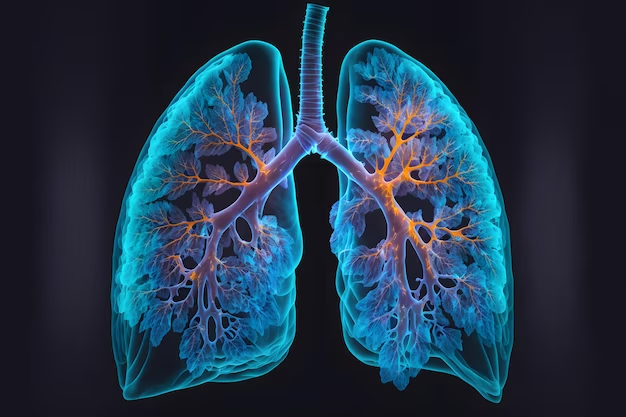


## <span style ='color:#241571'>GENDER RELATION TO COPD

In [52]:
# Create DataFrame for graph
gender_graph = pd.DataFrame(sample_train)

# Create DataFrame for graph
gender_graph_df = df_sample[df_sample['Gender'].isin(['Male', 'Female'])].dropna(subset=['Gender'])
gender_graph_df.head(2)


,Year,State Abbr,StratificationCategory1,Demographics,Geo Location,Yes_COPD,Race/Ethnicity,Gender,Yes_female,Longitude,Latitude
5,2014,UT,Gender,Male,POINT (-111.58713063499971 39.360700171000474),0,,Male,0,-111.587131,39.360700
7,2008,AL,Gender,Male,POINT (-86.63186076199969 32.84057112200048),0,,Male,0,-86.631861,32.840571


In [53]:
# def copd_KDE(sample_train):
#     '''KDE graph''' 
#     sns.kdeplot(data=sample_train, x='Yes_female', y='Yes_COPD', hue='Yes_COPD', palette='Blues')
#     plt.xlabel('Gender')
#     plt.ylabel('Density')
#     plt.title('Does Gender Relate to COPD?')
#     plt.show()

# copd_KDE(sample_train)

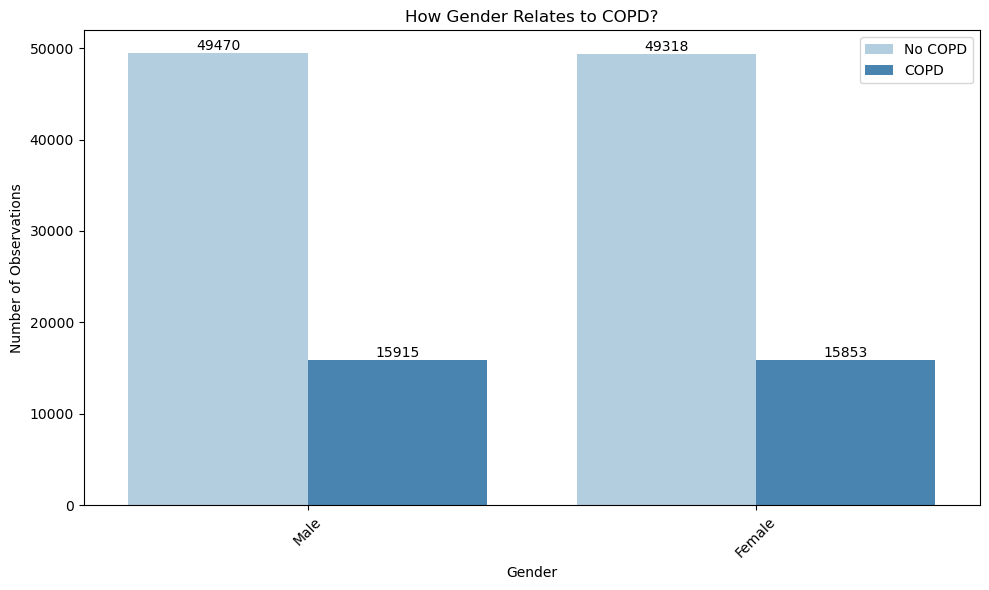

In [54]:
def gender_graph(sample_train):
    # Create DataFrame for graph
    gender_graph = pd.DataFrame(sample_train)
    
    # Create DataFrame for graph
    gender_graph_df = df_sample[df_sample['Gender'].isin(['Male', 'Female'])].dropna(subset=['Gender'])
    
    # Assuming you have a DataFrame 'df_sample' with the required data
    new_labels = {'no COPD': 'No COPD', 'COPD': 'COPD'}
    
    # Set a larger figure size
    plt.figure(figsize=(10, 6))
    
    # Visualizing the Gender vs COPD
    gg = sns.countplot(data=gender_graph_df, x='Gender', hue='Yes_COPD', palette='Blues')
    
    # Access the legend object
    legend = gg.legend()
    
    # Modify the legend labels
    legend.get_texts()[0].set_text(new_labels['no COPD'])
    legend.get_texts()[1].set_text(new_labels['COPD'])
    
    gg.set_xlabel('Gender')
    gg.set_ylabel('Number of Observations')
    plt.title('How Gender Relates to COPD?')
    
    # Rotate x-axis labels by 45 degrees
    plt.xticks(rotation=45)
    
    # Add count numbers on bars
    for p in gg.patches:
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy()    
        offset = width * 0.02  # Adjust the offset percentage as needed
        gg.annotate(format(height, '.0f'), (x + width / 2., y + height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
    # Use tight layout
    plt.tight_layout()
    
    plt.show()
gender_graph(sample_train)

Visual Findings:

Hypothesis 1 - 

* alpha = .05
* H0 =  Category of "male or female" gender has no relationship to COPD
* Ha = Category of "male or female" gender has a relationship to COPD
* Outcome: We accept or reject the Null Hypothesis

In [55]:
alpha = 0.05
gender_observed = pd.crosstab(sample_train.Yes_COPD, sample_train.Yes_female)
gender_observed

Yes_female,0,1
Yes_COPD,,
0,216088,29656
1,67161,9538


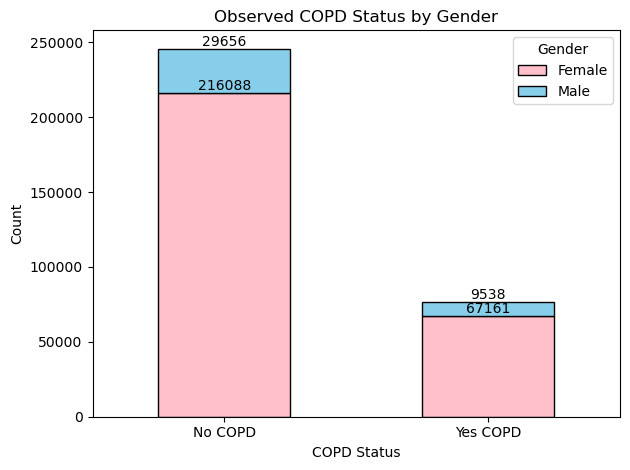

In [56]:
# Assuming you have a DataFrame 'df_sample' with the required data
new_labels = {'no COPD': 'No COPD', 'COPD': 'COPD'}
# Plot the observed data as a bar plot
go =gender_observed.plot(kind='bar', stacked=True, color=['pink','skyblue' ], edgecolor='black')
# Access the legend object
legend = go.legend()
    
# Modify the legend labels
legend.get_texts()[0].set_text(new_labels['no COPD'])
legend.get_texts()[1].set_text(new_labels['COPD'])

# Set the labels and title
plt.xlabel('COPD Status')
plt.ylabel('Count')
plt.title('Observed COPD Status by Gender')
plt.legend(title='Gender', loc='upper right', labels=['Female', 'Male'])

# Rename the x-axis labels
go.set_xticklabels(['No COPD', 'Yes COPD'], rotation=0)

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=0)
    
# Add count numbers on bars
for p in go.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()    
    offset = width * 0.02  # Adjust the offset percentage as needed
    go.annotate(format(height, '.0f'), (x + width / 2., y + height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')
    
# Use tight layout
plt.tight_layout()
plt.show()

In [57]:
import scipy.stats as stats
stats.chi2_contingency(gender_observed)

Chi2ContingencyResult(statistic=7.370486009104413, pvalue=0.0066303011850465145, dof=1, expected_freq=array([[215873.01400868,  29870.98599132],
       [ 67375.98599132,   9323.01400868]]))

In [58]:
chi2, p, degf, expected = stats.chi2_contingency(gender_observed)

In [59]:
print('Gender Observed')
print(gender_observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'The p-value is less than the alpha: {p < alpha}')
if p < alpha:
    print('We reject the null')
else:
    print("we fail to reject the null")

Gender Observed
[[216088  29656]
 [ 67161   9538]]

Expected
[[215873  29870]
 [ 67375   9323]]

----
chi^2 = 7.3705
The p-value is less than the alpha: True
We reject the null


Statistical Testing Findings: Ha = Category of "male or female" gender has a relationship to COPD

Finding 1: Overall, women smokers are about 50% more likely to develop COPD than men. general, women smoke less than men, suggesting that they may be more susceptible to developing COPD in response to cigarette smoke exposure than men. In a large population study, females appear to have more severe COPD with early-onset disease (<60 yr) and a greater susceptibility to COPD with lower tobacco exposure. (Barnes,2016)

Finding 2: Gender Disparity in COPD Diagnosis
The study reveals significant gender disparity in COPD diagnosis, with higher rates of undiagnosed COPD observed in men, irrespective of race. This suggests that men are less likely to receive timely COPD diagnoses compared to women. One possible contributing factor could be differences in symptom perception and attitudes toward medical care between genders. Women tend to report COPD symptoms earlier and more frequently, leading to earlier diagnosis and potentially explaining the lower rates of undiagnosed COPD among women. Addressing this gender disparity in COPD diagnosis is crucial to ensure timely interventions and improved healthcare outcomes for both men and women.(Mamary et al., 2018)

References :
- Barnes, P. J. (2016). Sex differences in chronic obstructive pulmonary disease mechanisms. American journal of respiratory and critical care medicine, 193(8), 813-814.
- Mamary, A. J., Stewart, J. I., Kinney, G. L., Hokanson, J. E., Shenoy, K., Dransfield, M. T., Foreman, M. G., Vance, G. B., Criner, G. J., & COPDGene® Investigators (2018). Race and Gender Disparities are Evident in COPD Underdiagnoses Across all Severities of Measured Airflow Obstruction. Chronic obstructive pulmonary diseases (Miami, Fla.), 5(3), 177–184. https://doi.org/10.15326/jcopdf.5.3.2017.0145

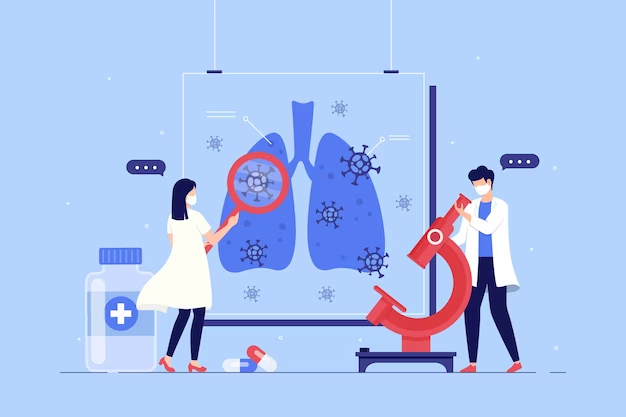

## <span style ='color:#241571'>RACE/ETHNICTY RELATION TO COPD

In [60]:
sample_train["Race/Ethnicity"].value_counts()

                                    119879
White, non-Hispanic                  40621
Hispanic                             40603
Black, non-Hispanic                  40248
American Indian or Alaska Native     23882
Asian or Pacific Islander            23829
Other, non-Hispanic                  16756
Multiracial, non-Hispanic            16625
Name: Race/Ethnicity, dtype: int64

In [61]:
# Create DataFrame for graph
race_graph_df = pd.DataFrame(sample_train)

# Filter the DataFrame to keep only 'Male' and 'Female' values and drop rows with blank values
race_graph_df = race_graph_df[race_graph_df['Race/Ethnicity'].isin(['White, non-Hispanic','Black, non-Hispanic', 'Hispanic', 'Asian or Pacific Islander', 'American Indian or Alaska Native', 'Other, non-Hispanic','Multiracial, non-Hispanic'])].dropna(subset=['Race/Ethnicity'])
race_graph_df.head(3)



,Year,State Abbr,StratificationCategory1,Demographics,Geo Location,Yes_COPD,Race/Ethnicity,Gender,Yes_female,Longitude,Latitude
9478,2016,VI,Race/Ethnicity,"Multiracial, non-Hispanic",POINT (-64.896335 18.335765),1,"Multiracial, non-Hispanic",,0,-64.896335,18.335765
965970,2020,MA,Race/Ethnicity,American Indian or Alaska Native,POINT (-72.08269067499964 42.27687047000046),0,American Indian or Alaska Native,,0,-72.082691,42.276870
124513,2011,AZ,Race/Ethnicity,American Indian or Alaska Native,POINT (-111.76381127699972 34.865970280000454),0,American Indian or Alaska Native,,0,-111.763811,34.865970


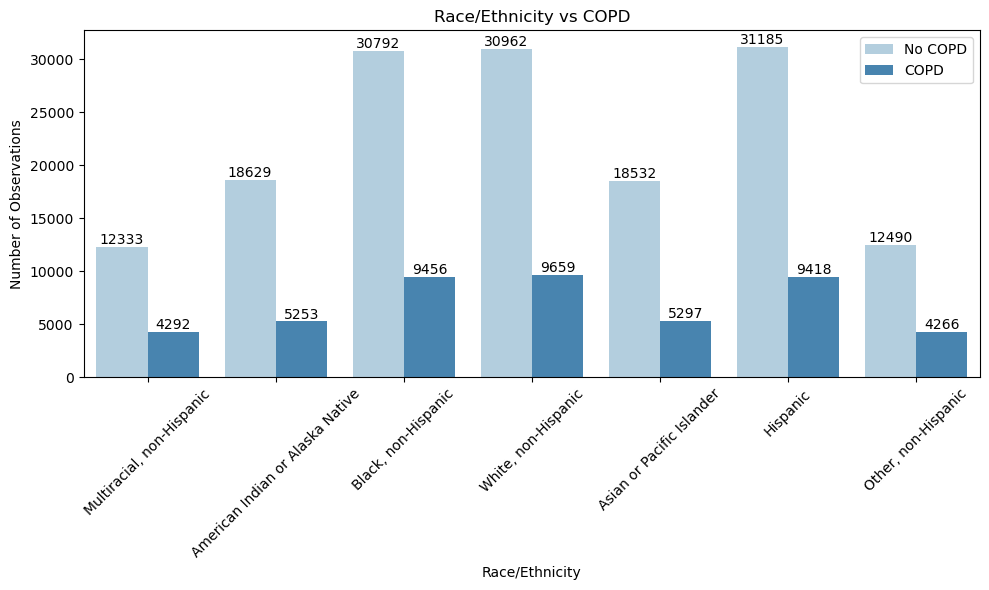

In [62]:

new_labels = {'no COPD': 'No COPD', 'COPD': 'COPD'}

# Set a larger figure size
plt.figure(figsize=(10, 6))

# Visualizing the Race/Ethnicity vs COPD
eg = sns.countplot(data=race_graph_df, x='Race/Ethnicity', hue='Yes_COPD', palette='Blues')

# Access the legend object
legend = eg.legend()

# Modify the legend labels
legend.get_texts()[0].set_text(new_labels['no COPD'])
legend.get_texts()[1].set_text(new_labels['COPD'])

eg.set_xlabel('Race/Ethnicity')
eg.set_ylabel('Number of Observations')
plt.title('Race/Ethnicity vs COPD')

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45)

# Add count numbers on bars
for p in eg.patches:
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy()    
    offset = width * 0.02  # Adjust the offset percentage as needed
    eg.annotate(format(height, '.0f'), (x + width / 2., y + height), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

# Use tight layout
plt.tight_layout()

plt.show()


##### Visual Findings: Race has a relationship with COPD

Hypothesis 2 - 

* alpha = .05
* H0 = Race has no relationship to COPD  prevalence
* Ha = Race has a relationship to COPD  prevalence
* Outcome: We accept or reject the Null Hypothesis

<Figure size 800x600 with 0 Axes>

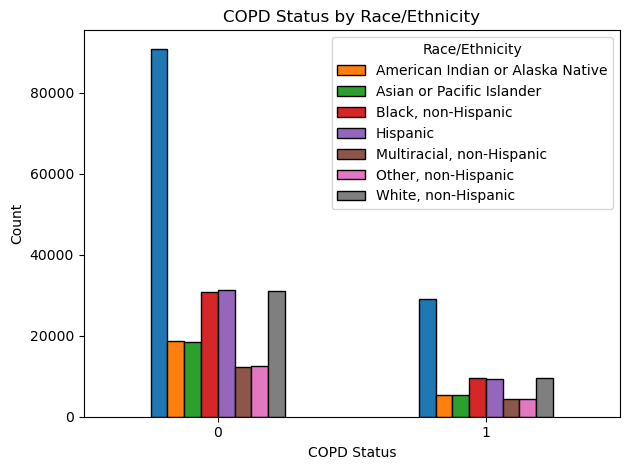

<Figure size 800x600 with 0 Axes>

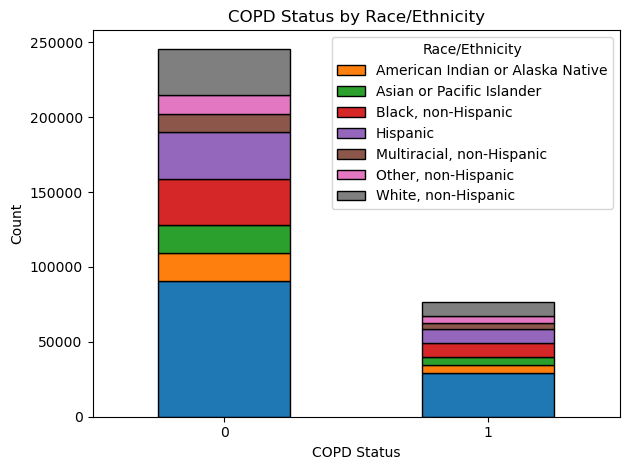

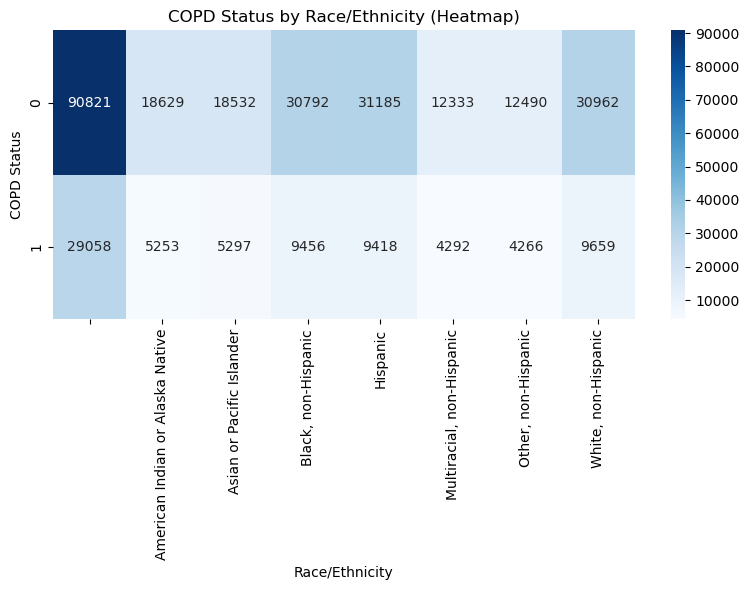

In [63]:
race_observed = pd.crosstab(sample_train['Yes_COPD'], sample_train['Race/Ethnicity'])

# Filter the DataFrame to keep only the specified race/ethnicity values and drop rows with missing values
race_observed_df = race_observed.dropna(subset=['White, non-Hispanic', 'Black, non-Hispanic', 'Hispanic', 'Asian or Pacific Islander', 'American Indian or Alaska Native', 'Other, non-Hispanic', 'Multiracial, non-Hispanic'])

# --- Classification Plot 1: Bar Plot ---
plt.figure(figsize=(8, 6))
race_observed_df.plot(kind='bar', edgecolor='black')
plt.xlabel('COPD Status')
plt.ylabel('Count')
plt.title('COPD Status by Race/Ethnicity')
plt.legend(title='Race/Ethnicity', loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Classification Plot 2: Stacked Bar Plot ---
plt.figure(figsize=(8, 6))
race_observed_df.plot(kind='bar', stacked=True, edgecolor='black')
plt.xlabel('COPD Status')
plt.ylabel('Count')
plt.title('COPD Status by Race/Ethnicity')
plt.legend(title='Race/Ethnicity', loc='upper right')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# --- Classification Plot 3: Heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(race_observed_df, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.xlabel('Race/Ethnicity')
plt.ylabel('COPD Status')
plt.title('COPD Status by Race/Ethnicity (Heatmap)')
plt.tight_layout()
plt.show()


In [64]:
alpha = 0.05
race_observed = pd.crosstab(sample_train['Yes_COPD'], sample_train['Race/Ethnicity'])
race_observed

Race/Ethnicity,,American Indian or Alaska Native,Asian or Pacific Islander,"Black, non-Hispanic",Hispanic,"Multiracial, non-Hispanic","Other, non-Hispanic","White, non-Hispanic"
Yes_COPD,,,,,,,,
0,90821,18629,18532,30792,31185,12333,12490,30962
1,29058,5253,5297,9456,9418,4292,4266,9659


In [65]:
stats.chi2_contingency(race_observed)

Chi2ContingencyResult(statistic=161.08030581395266, pvalue=1.900341137145157e-31, dof=7, expected_freq=array([[91363.57426274, 18201.22690832, 18160.83393344, 30674.27269936,
        30944.82941791, 12670.43787584, 12770.27711565, 30958.54778674],
       [28515.42573726,  5680.77309168,  5668.16606656,  9573.72730064,
         9658.17058209,  3954.56212416,  3985.72288435,  9662.45221326]]))

In [66]:
chi2, p, degf, expected = stats.chi2_contingency(race_observed)

In [67]:
print('Observed')
print(race_observed.values)
print('\nExpected')
print(expected.astype(int))
print('\n----')
print(f'chi^2 = {chi2:.4f}')
print(f'The p-value is less than the alpha: {p < alpha}')
if p < alpha:
    print('We reject the null')
else:
    print("we fail to reject the null")

Observed
[[90821 18629 18532 30792 31185 12333 12490 30962]
 [29058  5253  5297  9456  9418  4292  4266  9659]]

Expected
[[91363 18201 18160 30674 30944 12670 12770 30958]
 [28515  5680  5668  9573  9658  3954  3985  9662]]

----
chi^2 = 161.0803
The p-value is less than the alpha: True
We reject the null


#####  Findings:
Racial Disparities in COPD Diagnosis
The study also highlights racial disparities in COPD diagnosis, with COPD, once considered a disease primarily affecting white men, now recognized as increasingly prevalent among African American men and women. The risk for undiagnosed COPD was not uniform within the study population, indicating significant disparities by race. Understanding the population characteristics of the approximately 13 million individuals with undiagnosed COPD is essential to address and mitigate these disparities. Tailored interventions and targeted healthcare initiatives should be implemented to improve COPD diagnosis rates and healthcare access for racial minority groups. (Mamary et al., 2018)


- Mamary, A. J., Stewart, J. I., Kinney, G. L., Hokanson, J. E., Shenoy, K., Dransfield, M. T., Foreman, M. G., Vance, G. B., Criner, G. J., & COPDGene® Investigators (2018). Race and Gender Disparities are Evident in COPD Underdiagnoses Across all Severities of Measured Airflow Obstruction. Chronic obstructive pulmonary diseases (Miami, Fla.), 5(3), 177–184. https://doi.org/10.15326/jcopdf.5.3.2017.0145
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6296789/

## <span style ='color:#241571'>DOES YEAR HAVE A RELATIONSHIP TO COPD?

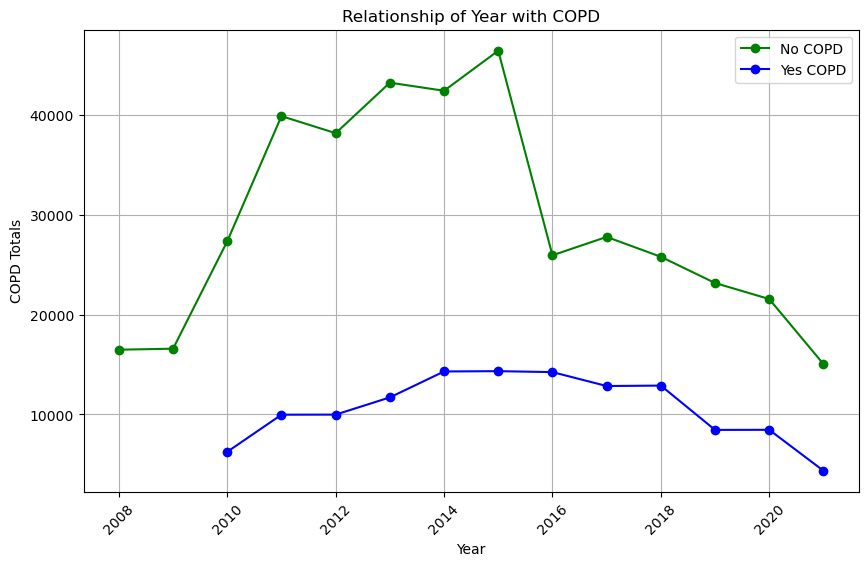

In [68]:
no_COPD_df = df_sample[df_sample['Yes_COPD'] == 0]

# Group by 'Year' and count the number of 'No_COPD' occurrences for each year
no_COPD_totals_by_year = no_COPD_df.groupby('Year').size()

# Filter the DataFrame for rows where 'Yes_COPD' is equal to "1" (Yes COPD)
yes_COPD_df = df_sample[df_sample['Yes_COPD'] == 1]

# Group by 'Year' and count the number of 'Yes_COPD' occurrences for each year
yes_COPD_totals_by_year = yes_COPD_df.groupby('Year').size()

# Create a time-line graph for the COPD totals over the years
plt.figure(figsize=(10, 6))
plt.plot(no_COPD_totals_by_year.index, no_COPD_totals_by_year.values, marker='o', linestyle='-', color='g', label='No COPD')
plt.plot(yes_COPD_totals_by_year.index, yes_COPD_totals_by_year.values, marker='o', linestyle='-', color='b', label='Yes COPD')
plt.title('Relationship of Year with COPD')
plt.xlabel('Year')
plt.ylabel('COPD Totals')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### DATA VISUALIZATION FINDINGS :
Overall COPD rates in US, dropped between 2014 and 2020

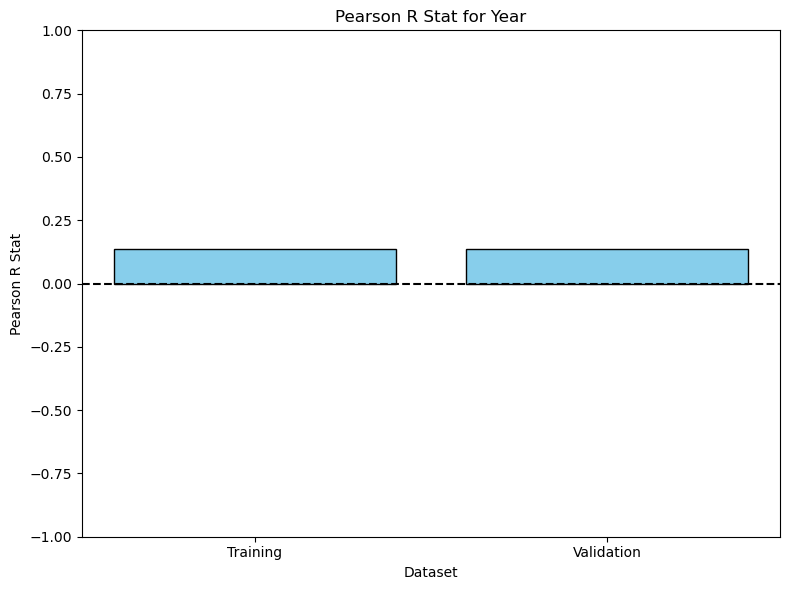

In [69]:
train_r, train_p = pearsonr(sample_train.Year, sample_train.Yes_COPD)
validate_r, validate_p = pearsonr(sample_validate.Year, sample_validate.Yes_COPD)

# Create a DataFrame to hold the correlation coefficients and p-values
correlation_df = pd.DataFrame({
    'Dataset': ['Training', 'Validation'],
    'Correlation': [train_r, validate_r],
    'p-value': [train_p, validate_p]
})

# Plot the Pearson correlation coefficients
plt.figure(figsize=(8, 6))
plt.bar(correlation_df['Dataset'], correlation_df['Correlation'], color='skyblue', edgecolor='black')
plt.xlabel('Dataset')
plt.ylabel('Pearson R Stat')
plt.title('Pearson R Stat for Year')
plt.ylim(-1, 1)  # Set the y-axis limits to show the range of correlation values (-1 to 1)
plt.axhline(y=0, color='black', linestyle='--')  # Add a horizontal line at y=0 for reference
plt.tight_layout()
plt.show()


In [70]:

'''Pearson R stat for year'''
alpha = 0.05
train_r, train_p = pearsonr(sample_train.Year, sample_train.Yes_COPD)
validate_r, validate_p = pearsonr(sample_validate.Year, sample_validate.Yes_COPD)
#    test_r, test_p = pearsonr(test.chlorides, test.quality)
print('train_r:', train_r)
print('train_p:',train_p)
print('validate_r:', validate_r)
print('validate_p:', validate_p)
print(f'The p-value is less than the alpha: {validate_p < alpha}')
if validate_p < alpha:
    print('Outcome: We reject the null')
else:
    print("Outcome: We fail to reject the null")

train_r: 0.135143646772403
train_p: 0.0
validate_r: 0.13482883003002175
validate_p: 0.0
The p-value is less than the alpha: True
Outcome: We reject the null


##### Findings: 
Findings: 1: COPD Rates from 2014 to 2018: Over this period, COPD rates remained relatively stable, showing little change on average year to year. However, there was a significant decline in both rates and counts from 2018 to 2019, which is likely attributed to a change in the question format used for data collection. The subsequent increase in COPD rates and counts from 2019 to 2020 was not statistically significant (ALA, 2023).

Findings: 2: Impact of COVID-19 on COPD: The similarity in symptoms between COPD and COVID-19 has resulted in delayed diagnosis for some COPD patients infected with COVID-19. Misdiagnosis as a COPD exacerbation has been reported, further complicating timely treatment. COVID-19 can adversely affect the immune system, making it harder for COPD patients to combat the infection. The combination of COVID-19 symptoms and worsened COPD symptoms can lead to severe shortness of breath and breathing difficulties in affected individuals (Awatade, 2023).


- American Lung Association.[ALA] (2023). COPD Prevalence. Retrieved from https://www.lung.org/research/trends-in-lung-disease/copd-trends-brief/copd-prevalence
- Awatade, N. T., Wark, P. A. B., Chan, A. S. L., Mamun, S. M. A. A., Mohd Esa, N. Y., Matsunaga, K., Rhee, C. K., Hansbro, P. M., Sohal, S. S., & On Behalf Of The Asian Pacific Society Of Respirology Apsr Copd Assembly (2023). The Complex Association between COPD and COVID-19. Journal of clinical medicine, 12(11), 3791. https://doi.org/10.3390/jcm12113791

## <span style ='color:#241571'>DOES STATE HAVE A RELATIONSHIP TO COPD?

In [ ]:
import folium
map_sample = sample_train.sample(10000)
map_sample.drop(map_sample[map_sample['Geo Location'] == ''].index, inplace=True)

map_sample.dropna(inplace=True)
# Create a folium map centered at the USA
map_usa = folium.Map(location=[37.0902, -95.7129], zoom_start=4)

# Get the count of 'Yes' for each state
yes_count_per_state = map_sample[map_sample['Yes_COPD'] == 1].groupby('State Abbr').size()

# Add markers to the map for each state with COPD values
for idx, row in map_sample.iterrows():
    # Convert 1 to 'Yes' and 0 to 'No'
    COPD_status = 'Yes' if row['Yes_COPD'] == 1 else 'No'
    
    # Get the count of 'Yes' for the current state
    count_for_state = yes_count_per_state.get(row['State Abbr'], 0)
    
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['State Abbr']} State # of {COPD_status} COPD Observations:  {count_for_state}",
        tooltip=row['State Abbr'],
        icon=folium.Icon(icon='info-sign')
    ).add_to(map_usa)
#saves map HTML image 
map_usa.save("map_usa.html")
# Display the map
map_usa

https://www.cdc.gov/copd/data-and-statistics/state-estimates.html

In [71]:
#Splitting the data in to X and Y to take out the data with curn and those without 
sample_X_train = sample_train.select_dtypes(exclude=['object']).drop(columns=['Yes_COPD'])
sample_y_train = sample_train.select_dtypes(exclude=['object']).Yes_COPD

sample_X_validate = sample_validate.select_dtypes(exclude=['object']).drop(columns=['Yes_COPD'])
sample_y_validate = sample_validate.select_dtypes(exclude=['object']).Yes_COPD

sample_X_test = sample_test.select_dtypes(exclude=['object']).drop(columns=['Yes_COPD'])
sample_y_test = sample_test.select_dtypes(exclude=['object']).Yes_COPD

# <span style ='color:#241571'> CLASSIFICATION MODELING


###  <span style ='color:#757C88'> BASELINE

In [82]:
sample_X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322443 entries, 9478 to 402822
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Year        322443 non-null  int64  
 1   Yes_female  322443 non-null  int64  
 2   Longitude   322443 non-null  float64
 3   Latitude    322443 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 12.3 MB


In [79]:
(sample_y_train==0).mean()

0.7621316015543833

## <span style ='color:#241571'> TRAIN
### <span style ='color:#757C88'> DECISION TREE

In [89]:
#Make 
sample_tree = DecisionTreeClassifier(max_depth=4, random_state=42)

In [90]:
#Fit
sample_tree = sample_tree.fit(sample_X_train, sample_y_train)

[Text(0.4375, 0.9, 'Year <= 2009.5\ngini = 0.363\nsamples = 322443\nvalue = [245744, 76699]'),
 Text(0.375, 0.7, 'gini = 0.0\nsamples = 19792\nvalue = [19792, 0]'),
 Text(0.5, 0.7, 'Year <= 2015.5\ngini = 0.378\nsamples = 302651\nvalue = [225952, 76699]'),
 Text(0.25, 0.5, 'Year <= 2013.5\ngini = 0.342\nsamples = 182321\nvalue = [142447, 39874]'),
 Text(0.125, 0.3, 'Latitude <= 19.82\ngini = 0.324\nsamples = 111738\nvalue = [88999, 22739]'),
 Text(0.0625, 0.1, 'gini = 0.422\nsamples = 2249\nvalue = [1568, 681]'),
 Text(0.1875, 0.1, 'gini = 0.322\nsamples = 109489\nvalue = [87431, 22058]'),
 Text(0.375, 0.3, 'Longitude <= -67.788\ngini = 0.368\nsamples = 70583\nvalue = [53448, 17135]'),
 Text(0.3125, 0.1, 'gini = 0.365\nsamples = 68518\nvalue = [52066, 16452]'),
 Text(0.4375, 0.1, 'gini = 0.443\nsamples = 2065\nvalue = [1382, 683]'),
 Text(0.75, 0.5, 'Year <= 2018.5\ngini = 0.425\nsamples = 120330\nvalue = [83505, 36825]'),
 Text(0.625, 0.3, 'Year <= 2016.5\ngini = 0.446\nsamples = 7166

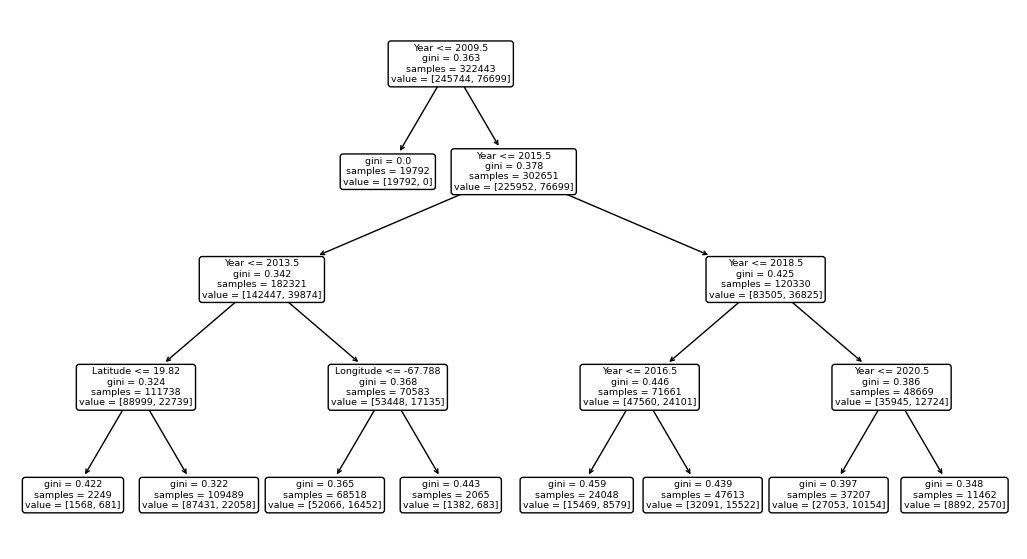

In [91]:
plt.figure(figsize=(13, 7))
plot_tree(sample_tree, feature_names=sample_X_train.columns, rounded=True)

In [92]:
#Dataframe of predictions
COPD_y_prediction = pd.DataFrame({'COPD': sample_y_train,'Baseline': 0, 'Model_1':sample_tree.predict(sample_X_train)})
COPD_y_prediction.head(3)

,COPD,Baseline,Model_1
9478,1,0,0
857250,1,0,0
446428,0,0,0


In [93]:
y_prediction_prob = sample_tree.predict_proba(sample_X_train)
print(y_prediction_prob[0:5])

[[0.64325516 0.35674484]
 [0.75988791 0.24011209]
 [0.6739966  0.3260034 ]
 [0.72709436 0.27290564]
 [0.75988791 0.24011209]]


In [96]:
print('Accuracy of Decision Tree classifier on training set: {:.4f}'
      .format(sample_tree.score(sample_X_train, sample_y_train)))

Accuracy of Decision Tree classifier on training set: 0.76


In [97]:
confusion_matrix(COPD_y_prediction.COPD, COPD_y_prediction.Model_1)
print(classification_report(COPD_y_prediction.COPD,COPD_y_prediction.Model_1))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87    245744
           1       0.00      0.00      0.00     76699

    accuracy                           0.76    322443
   macro avg       0.38      0.50      0.43    322443
weighted avg       0.58      0.76      0.66    322443



/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Decision Tree Model is slightly higher than baseline average in sample data. This model can be used on validation.

###  <span style ='color:#757C88'>LOGISTIC REGRESSION

In [99]:
# Make
log_sample = LogisticRegression(C=1, random_state=42)

In [100]:
#Fit 
log_sample.fit(sample_X_train, sample_y_train)

LogisticRegression(C=1, random_state=42)

In [101]:
# Use
y_prediction = log_sample.predict(sample_X_train)
y_prediction

array([0, 0, 0, ..., 0, 0, 0])

In [102]:
#Dataframe of predictions
COPD_y_prediction.head(3)

,COPD,Baseline,Model_1
9478,1,0,0
857250,1,0,0
446428,0,0,0


In [103]:
COPD_y_prediction['Model_2'] = y_prediction
print('Accuracy of Logistic Regression training set: {:.4f}'
      .format(log_sample.score(sample_X_train, sample_y_train)))

Accuracy of Logistic Regression training set: 0.76


In [104]:
confusion_matrix(COPD_y_prediction.COPD, COPD_y_prediction.Model_2)
print(classification_report(COPD_y_prediction.COPD,COPD_y_prediction.Model_2))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87    245744
           1       0.00      0.00      0.00     76699

    accuracy                           0.76    322443
   macro avg       0.38      0.50      0.43    322443
weighted avg       0.58      0.76      0.66    322443



###  <span style ='color:#757C88'>RANDOM FOREST

In [105]:
#Make

rf_sample = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=42)

In [106]:
#Fit
rf_sample.fit(sample_X_train, sample_y_train)

RandomForestClassifier(max_depth=10, random_state=42)

In [107]:
#Use
rf_sample.score(sample_X_train,sample_y_train)

0.76220913463775

In [108]:
# now use the model to make predictions
rf_y_prediction = rf_sample.predict(sample_X_train)
rf_y_prediction

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
COPD_y_prediction['Model_3'] = rf_y_prediction

In [110]:
#Dataframe of predictions
COPD_y_prediction.head(3)

,COPD,Baseline,Model_1,Model_2,Model_3
9478,1,0,0,0,0
857250,1,0,0,0,0
446428,0,0,0,0,0


In [113]:
print('Accuracy of Random Forest training set: {:.4f}'
      .format(rf_sample.score(sample_X_train, sample_y_train)))

Accuracy of Random Forest training set: 0.76


In [114]:
confusion_matrix(COPD_y_prediction.COPD, COPD_y_prediction.Model_3)
print(classification_report(COPD_y_prediction.COPD,COPD_y_prediction.Model_3))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87    245744
           1       0.68      0.00      0.00     76699

    accuracy                           0.76    322443
   macro avg       0.72      0.50      0.43    322443
weighted avg       0.74      0.76      0.66    322443



## <span style ='color:#241571'>VALIDATE 
### <span style ='color:#757C88'> DECISION TREE

In [115]:
#Dataframe of validate predictions
COPD_y_val_prediction = pd.DataFrame({'COPD': sample_y_validate,'Baseline': 0, 'Model_1':sample_tree.predict(sample_X_validate)})
COPD_y_val_prediction.head(3)

,COPD,Baseline,Model_1
707167,1,0,0
709842,0,0,0
505347,1,0,0


In [116]:
COPD_y_val_prediction_prob = sample_tree.predict_proba(sample_X_validate)
print(COPD_y_val_prediction_prob[0:5])

[[0.6739966  0.3260034 ]
 [0.6739966  0.3260034 ]
 [0.64325516 0.35674484]
 [0.79853684 0.20146316]
 [0.79853684 0.20146316]]


In [134]:
print('Accuracy of Decision Tree classifier on validation set: {:.4f}'
      .format(sample_tree.score(sample_X_validate, sample_y_validate)))

Accuracy of Decision Tree classifier on validation set: 0.7619


In [118]:
confusion_matrix(COPD_y_val_prediction.COPD, COPD_y_val_prediction.Model_1)

array([[81894,     0],
       [25588,     0]])

In [119]:
print(classification_report(COPD_y_val_prediction.COPD,COPD_y_val_prediction.Model_1))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     81894
           1       0.00      0.00      0.00     25588

    accuracy                           0.76    107482
   macro avg       0.38      0.50      0.43    107482
weighted avg       0.58      0.76      0.66    107482



Findings: Decision Tree Model is  higher than baseline average in validate data. This model can be used on test.

### <span style ='color:#757C88'> LOGISTIC REGRESSION VALIDATE

In [120]:
# USE
COPD_val_y_prediction = log_sample.predict(sample_X_validate)
COPD_val_y_prediction

array([0, 0, 0, ..., 0, 0, 0])

In [121]:
#Dataframe of predictions
COPD_y_val_prediction.head(2)

,COPD,Baseline,Model_1
707167,1,0,0
709842,0,0,0


In [135]:
COPD_y_val_prediction['Model_2'] = COPD_val_y_prediction
print('Accuracy of Logistic Regression validation set: {:.4f}'
      .format(log_sample.score(sample_X_validate, sample_y_validate)))

Accuracy of Logistic Regression validation set: 0.7619


In [123]:
confusion_matrix(COPD_y_val_prediction.COPD, COPD_y_val_prediction.Model_2)
print(classification_report(COPD_y_val_prediction.COPD, COPD_y_val_prediction.Model_2))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     81894
           1       0.00      0.00      0.00     25588

    accuracy                           0.76    107482
   macro avg       0.38      0.50      0.43    107482
weighted avg       0.58      0.76      0.66    107482



### <span style ='color:#757C88'> RANDOM FOREST VALIDATE

In [124]:
#score on my train data
rf_sample.score(sample_X_validate,sample_y_validate)

0.7620345732308665

In [125]:
# use the model to make predictions
COPD_val_rf_y_prediction = rf_sample.predict(sample_X_validate)
COPD_y_val_prediction['Model_3'] =COPD_val_rf_y_prediction

In [126]:
COPD_y_val_prediction.head(3)

,COPD,Baseline,Model_1,Model_2,Model_3
707167,1,0,0,0,0
709842,0,0,0,0,0
505347,1,0,0,0,0


In [136]:
print('Accuracy of Random Forest validation set: {:.4f}'
      .format(rf_sample.score(sample_X_validate, sample_y_validate)))

Accuracy of Random Forest validation set: 0.7620


In [128]:
confusion_matrix(COPD_y_val_prediction.COPD, COPD_y_val_prediction.Model_3)
print(classification_report(COPD_y_val_prediction.COPD, COPD_y_val_prediction.Model_3))

              precision    recall  f1-score   support

           0       0.76      1.00      0.86     81894
           1       0.79      0.00      0.00     25588

    accuracy                           0.76    107482
   macro avg       0.78      0.50      0.43    107482
weighted avg       0.77      0.76      0.66    107482



###  <span style ='color:#241571'>TOP MODEL SELECTION: DECISION TREE because it is the most consistant Model of 79% and beat the baseline of 73% consistently throughout training and validation datasets. 

## <span style ='color:#241571'>TEST

In [138]:
#Dataframe of validate predictions
COPD_test_prediction = pd.DataFrame({'COPD': sample_y_test,'Baseline': 0, 'Model_1':sample_tree.predict(sample_X_test)})
COPD_test_prediction.head(3)

,COPD,Baseline,Model_1
632323,0,0,0
799262,0,0,0
815940,0,0,0


In [140]:
COPD_test_prediction_prob = sample_tree.predict_proba(sample_X_test)
print(COPD_test_prediction_prob[0:5])

[[0.66924939 0.33075061]
 [0.75988791 0.24011209]
 [0.79853684 0.20146316]
 [0.79853684 0.20146316]
 [0.69719876 0.30280124]]


In [141]:
print('Accuracy of Decision Tree classifier on Test set: {:.4f}'
      .format(sample_tree.score(sample_X_test, sample_y_test)))

Accuracy of Decision Tree classifier on Test set: 0.7628


In [142]:
confusion_matrix(COPD_test_prediction.COPD, COPD_test_prediction.Model_1)
print(classification_report(COPD_test_prediction.COPD,COPD_test_prediction.Model_1))

              precision    recall  f1-score   support

           0       0.76      1.00      0.87     81991
           1       0.00      0.00      0.00     25491

    accuracy                           0.76    107482
   macro avg       0.38      0.50      0.43    107482
weighted avg       0.58      0.76      0.66    107482



In [143]:
COPD_test_prediction.to_csv('COPD_Predictions.csv',index =False)

### Findings: 
 The predictive models, including the Decision Tree Test Model, exhibited similar performance and closely aligned with the baseline accuracy of 76.21%. The Decision Tree Test Model showed a marginal improvement at 76.28%. Interestingly, all three models demonstrated consistency across train, validate, and test datasets. These results align with existing studies that suggest COPD rates in the US have remained relatively stable over time.

## <span style ='color:#241571'> NEXT STEPS
- Time-series if time permits to further explore the drop from 2008-2016.
- Melt Observation data to refine the observations
- Select a few areas to see if there are clusters with COPD data based on Geo Location


###  <span style ='color:#241571'> START OF NEXT STEPS
#### Time series 

In [ ]:
# # Make a copy of 'sample_train' to create 'time_graph_df'
# time_graph_df = sample_train.copy()

# # Convert 'Year' column to datetime format
# time_graph_df['Year'] = pd.to_datetime(time_graph_df['Year'], format='%Y')

#######-----

# time_graph_df.index.dtype

# # Set 'Year' as the index
# time_graph_df.set_index('Year', inplace=True)
# #####
# time_graph_df.head()
#######
# pd.to_datetime(time_graph_df.index, format='%Y')

# import pandas as pd
# import matplotlib.pyplot as plt

# # Assuming you have the yr_df DataFrame with 'Observations' as the column to plot

# # Convert the date strings to datetime objects
# start_date_train = pd.to_datetime('2008-01-01 00:00:00')
# end_date_train = pd.to_datetime('2020-12-31 00:00:00')

# # Ensure the index is unique and sorted in ascending order
# yr_df_sorted = yr_df.sort_index()

# # Select rows within the specified time range for training data
# year_train_human = yr_df_sorted.loc[start_date_train:end_date_train]

# # Plot the 'Observations' for the selected training data
# plt.plot(year_train_human.index, year_train_human['Observations'])

# # Set labels and title
# plt.xlabel('Date')
# plt.ylabel('Observations')
# plt.title('Observations over Time (2008-2020)')

# # Rotate the x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# # Display the plot
# plt.tight_layout()
# plt.show()
###########



# # Resample the data by year and calculate the count of 'Yes_COPD' for each year
# yearly_COPD_resampled = df.resample('Y').sum()

# # Create the bar plot
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# sns.barplot(x=yearly_COPD_resampled.index.year, y='Yes_COPD', data=yearly_COPD_resampled)
# plt.xlabel('Year')
# plt.ylabel('Count')
# plt.title('Counts of Yes_COPD over the Years')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# index_data_type = df.index.dtype

#### Melt DataValue

In [ ]:
# Tried to  Melt the DataFrame to convert 'Year' column into rows

# time_df = df_sample.melt(id_vars='Year', value_vars='Yes_COPD', var_name='COPDCase', value_name='Value')

# # Filter the DataFrame for 'Yes_COPD' values 0 and 1
# filtered_df = time_df[time_df['COPDCase'] == 'Yes_COPD']

# # Create a line plot
# plt.figure(figsize=(10, 6))
# plt.plot(filtered_df[filtered_df['Value'] == 1]['Year'], filtered_df[filtered_df['Value'] == 1]['Value'], marker='o', linestyle='-', color='b', label='Yes_COPD=1')
# plt.plot(filtered_df[filtered_df['Value'] == 0]['Year'], filtered_df[filtered_df['Value'] == 0]['Value'], marker='o', linestyle='-', color='r', label='Yes_COPD=0')
# plt.title('COPD Cases over the Years')
# plt.xlabel('Year')
# plt.ylabel('COPD Cases')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.show()